In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid, save_image

from tensorboardX import SummaryWriter
from tqdm import tqdm
from copy import deepcopy

import matplotlib.pyplot as plt
from utils import *
from models import *
from PIL import Image
!mkdir generated_images


A subdirectory or file generated_images already exists.


In [2]:
# training hyperparameters given by code author

lr_gen = 0.0001 #Learning rate for generator
lr_dis = 0.0003 #Learning rate for discriminator
latent_dim = 256 #Latent dimension
epoch = 200 #Number of epoch
weight_decay = 1e-3 #Weight decay
drop_rate = 0.5 #dropout
n_critic = 5 #
max_iter = 500000
img_name = "img_name"
lr_decay = True

# architecture details by authors
image_size = 64 #H,W size of image for discriminator
initial_size = 8 #Initial size for generator
patch_size = 4 #Patch size for generated image
num_classes = 1 #Number of classes for discriminator 
output_dir = 'checkpoint' #saved model path
dim = 384 #Embedding dimension 
optimizer = 'Adam' #Optimizer
loss = "wgangp_eps" #Loss function
phi = 1 #
beta1 = 0 #
beta2 = 0.99 #
diff_aug = "translation,cutout,color" #data augmentation


## Training & Saving Model for CIFAR-10
As we mentioned above we run the training for 10 epochs due to limitation of Google Colab and showed the decrease in FID score from 253 to 138 in 10 epochs.

In [3]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)

generator= Generator(depth1=2, depth2=2, depth3=1, initial_size=16, dim=384, heads=2, mlp_ratio=2, drop_rate=0.5,latent_dim=256).to(device).apply(inits_weight)

discriminator = Discriminator(diff_aug = diff_aug, image_size=64, patch_size=16, input_channel=3, num_classes=1,
                 dim=384, depth=2, heads=2, mlp_ratio=2,
                 drop_rate=0.5).to(device).apply(inits_weight)

(1)

c:\Users\aashr\Desktop\research\testing_grounds\utils.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data, 1.)


1

In [4]:
if optimizer == 'Adam':
    optim_gen = optim.Adam(filter(lambda p: p.requires_grad, generator.parameters()), lr=lr_gen, betas=(beta1, beta2))

    optim_dis = optim.Adam(filter(lambda p: p.requires_grad, discriminator.parameters()),lr=lr_dis, betas=(beta1, beta2))

gen_scheduler = LinearLrDecay(optim_gen, lr_gen, 0.0, 0, max_iter * n_critic)
dis_scheduler = LinearLrDecay(optim_dis, lr_dis, 0.0, 0, max_iter * n_critic)

#RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

print("optimizer:",optimizer)


optimizer: Adam


In [5]:
a = torch.cuda.FloatTensor(np.random.normal(0, 1, (1, latent_dim)))
print(a.shape)
generator(a).shape

torch.Size([1, 256])


torch.Size([1, 3, 64, 64])

In [6]:
def compute_gradient_penalty(D, real_samples, fake_samples, phi):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.Tensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(
        real_samples.get_device())
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha)
                    * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones([real_samples.shape[0], 1], requires_grad=False).to(
        real_samples.get_device())
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.contiguous().view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - phi) ** 2).mean()
    return gradient_penalty


In [7]:
def train(
    noise,
    generator,
    discriminator,
    optim_gen,
    optim_dis,
    epoch,
    schedulers,
    img_size=64,
    latent_dim=latent_dim,
    n_critic=n_critic,
    device="cuda:0",
):
    generator = generator.train()
    discriminator = discriminator.train()

    transform = transforms.Compose(
        [
            transforms.Resize(size=(img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_set = torchvision.datasets.ImageFolder(
        root=r"C:\Users\aashr\Desktop\research\testing_grounds\images",
        transform=transform,
    )
    train_loader = torch.utils.data.DataLoader(
        dataset=train_set, batch_size=8, shuffle=True
    )

    for index, (img, _) in enumerate(train_loader):
        real_imgs = img.type(torch.cuda.FloatTensor)

        noise = torch.cuda.FloatTensor(
            np.random.normal(0, 1, (img.shape[0], latent_dim))
        )

        optim_dis.zero_grad()
        real_valid = discriminator(real_imgs)
        fake_imgs = generator(noise).detach()
        fake_valid = discriminator(fake_imgs)

        gradient_penalty = compute_gradient_penalty(
            discriminator, real_imgs, fake_imgs.detach(), phi
        )
        loss_dis = (
            -torch.mean(real_valid)
            + torch.mean(fake_valid)
            + gradient_penalty * 10 / (phi**2)
        )
        loss_dis.backward()
        optim_dis.step()

        optim_gen.zero_grad()
        if schedulers:
            gen_scheduler, dis_scheduler = schedulers
            g_lr = gen_scheduler.step(1)
            d_lr = dis_scheduler.step(1)

        gener_noise = torch.cuda.FloatTensor(np.random.normal(0, 1, (8, latent_dim)))
        generated_imgs = generator(gener_noise)
        fake_valid = discriminator(generated_imgs)
        gener_loss = -torch.mean(fake_valid).to(device)
        gener_loss.backward()
        optim_gen.step()

    sample_imgs = generated_imgs
    img_grid = make_grid(sample_imgs, normalize=True, scale_each=True)
    save_image(
        sample_imgs,
        f"generated_images/generated_img_{epoch}_{index % len(train_loader)}.jpg",
        normalize=True,
        scale_each=True,
    )
    display(
        Image.open(
            f"generated_images/generated_img_{epoch}_{index % len(train_loader)}.jpg"
        )
    )
    tqdm.write(
        "[Epoch %d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        % (
            epoch + 1,
            index % len(train_loader),
            len(train_loader),
            loss_dis.item(),
            gener_loss.item(),
        )
    )

C:\Users\aashr\AppData\Roaming\Python\Python310\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3436.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


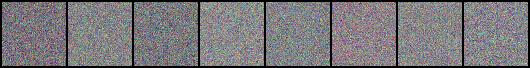

[Epoch 1] [Batch 295/296] [D loss: 2.418753] [G loss: -7.705374]


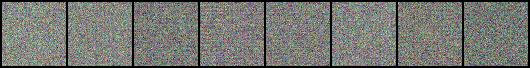

[Epoch 2] [Batch 295/296] [D loss: 3.367588] [G loss: -3.011750]


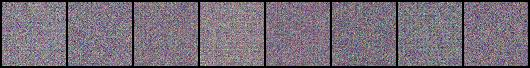

[Epoch 3] [Batch 295/296] [D loss: 1.791642] [G loss: 9.417126]


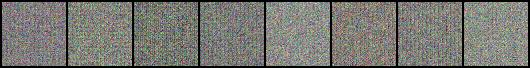

[Epoch 4] [Batch 295/296] [D loss: 1.535516] [G loss: 5.681506]


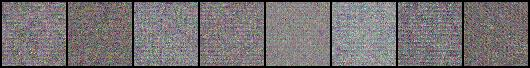

[Epoch 5] [Batch 295/296] [D loss: 0.095399] [G loss: -4.193942]


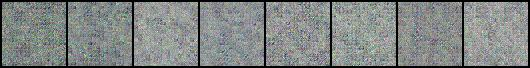

[Epoch 6] [Batch 295/296] [D loss: 6.181056] [G loss: 2.430942]


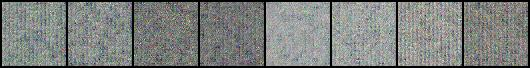

[Epoch 7] [Batch 295/296] [D loss: -2.995013] [G loss: 6.124985]


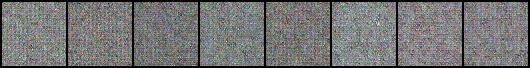

[Epoch 8] [Batch 295/296] [D loss: 2.384279] [G loss: 2.034034]


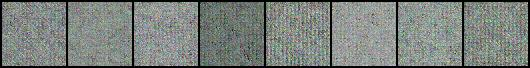

[Epoch 9] [Batch 295/296] [D loss: -3.620809] [G loss: 5.312344]


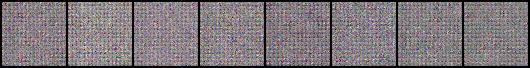

[Epoch 10] [Batch 295/296] [D loss: 2.559997] [G loss: 4.607905]


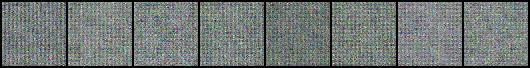

[Epoch 11] [Batch 295/296] [D loss: -0.987911] [G loss: 8.966709]


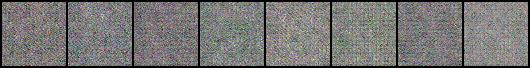

[Epoch 12] [Batch 295/296] [D loss: 1.647772] [G loss: -6.721693]


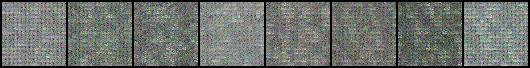

[Epoch 13] [Batch 295/296] [D loss: -0.643798] [G loss: 10.825742]


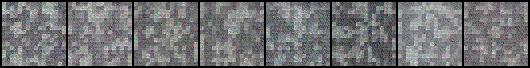

[Epoch 14] [Batch 295/296] [D loss: 2.261554] [G loss: 3.188371]


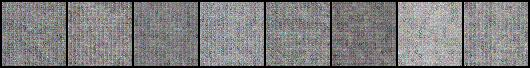

[Epoch 15] [Batch 295/296] [D loss: -0.382957] [G loss: 3.318949]


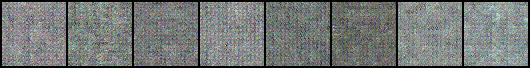

[Epoch 16] [Batch 295/296] [D loss: 2.451835] [G loss: 8.067507]


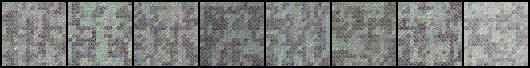

[Epoch 17] [Batch 295/296] [D loss: 2.919613] [G loss: 5.290556]


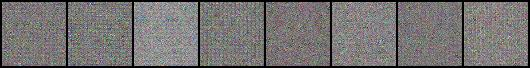

[Epoch 18] [Batch 295/296] [D loss: 2.422074] [G loss: 6.042594]


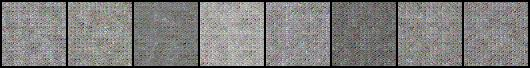

[Epoch 19] [Batch 295/296] [D loss: 3.915414] [G loss: -0.834588]


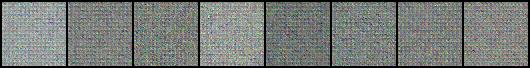

[Epoch 20] [Batch 295/296] [D loss: -1.313601] [G loss: 5.115303]


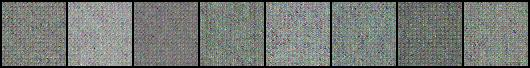

[Epoch 21] [Batch 295/296] [D loss: -2.885096] [G loss: -0.735568]


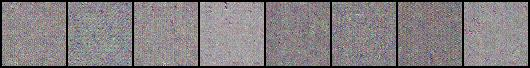

[Epoch 22] [Batch 295/296] [D loss: 3.247393] [G loss: 1.503470]


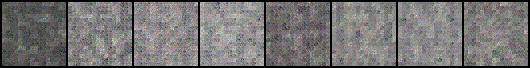

[Epoch 23] [Batch 295/296] [D loss: 4.026454] [G loss: 2.091962]


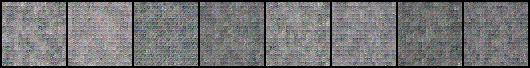

[Epoch 24] [Batch 295/296] [D loss: 1.973593] [G loss: 4.326398]


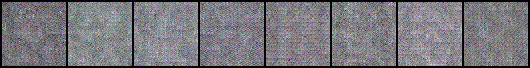

[Epoch 25] [Batch 295/296] [D loss: -0.688248] [G loss: 7.474136]


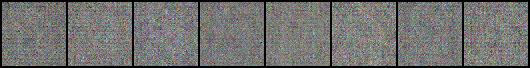

[Epoch 26] [Batch 295/296] [D loss: -0.496520] [G loss: 4.248885]


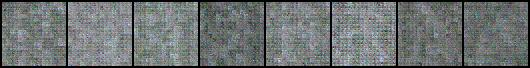

[Epoch 27] [Batch 295/296] [D loss: 1.290837] [G loss: 7.805949]


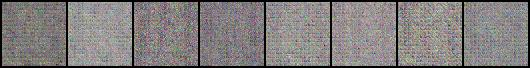

[Epoch 28] [Batch 295/296] [D loss: -3.866097] [G loss: -3.823782]


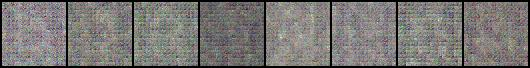

[Epoch 29] [Batch 295/296] [D loss: 3.387597] [G loss: -1.457332]


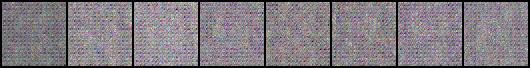

[Epoch 30] [Batch 295/296] [D loss: -0.052249] [G loss: 4.422149]


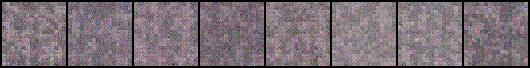

[Epoch 31] [Batch 295/296] [D loss: -2.423458] [G loss: 9.151705]


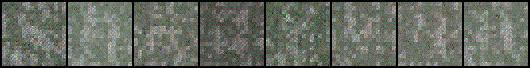

[Epoch 32] [Batch 295/296] [D loss: 0.710928] [G loss: 1.499375]


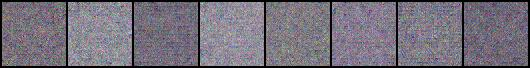

[Epoch 33] [Batch 295/296] [D loss: 7.634995] [G loss: -1.751999]


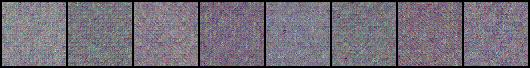

[Epoch 34] [Batch 295/296] [D loss: 0.130707] [G loss: -4.996484]


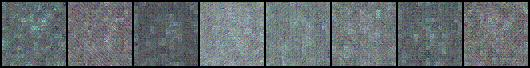

[Epoch 35] [Batch 295/296] [D loss: 0.391859] [G loss: 9.721600]


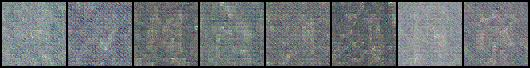

[Epoch 36] [Batch 295/296] [D loss: 0.277812] [G loss: 3.310057]


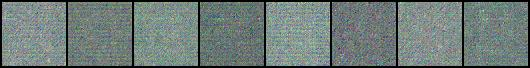

[Epoch 37] [Batch 295/296] [D loss: 1.993624] [G loss: -1.808636]


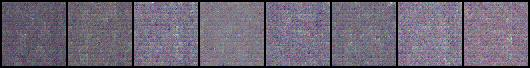

[Epoch 38] [Batch 295/296] [D loss: 0.030367] [G loss: 0.377588]


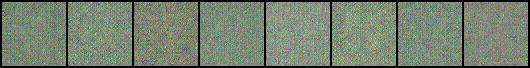

[Epoch 39] [Batch 295/296] [D loss: 0.263609] [G loss: 0.194014]


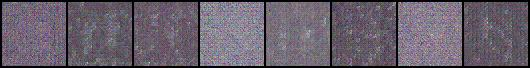

[Epoch 40] [Batch 295/296] [D loss: 3.951953] [G loss: -2.959452]


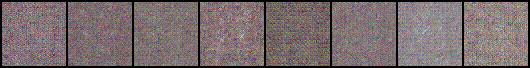

[Epoch 41] [Batch 295/296] [D loss: -0.403188] [G loss: 1.431323]


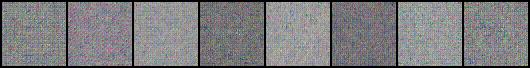

[Epoch 42] [Batch 295/296] [D loss: -2.178060] [G loss: -2.466027]


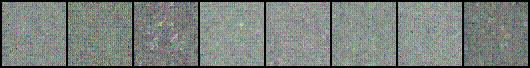

[Epoch 43] [Batch 295/296] [D loss: -4.067400] [G loss: 10.767802]


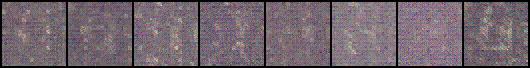

[Epoch 44] [Batch 295/296] [D loss: 0.186144] [G loss: 8.859695]


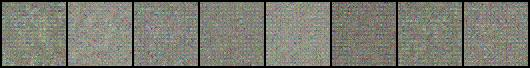

[Epoch 45] [Batch 295/296] [D loss: 4.534976] [G loss: -0.221971]


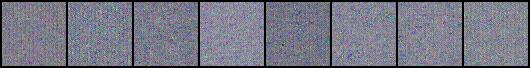

[Epoch 46] [Batch 295/296] [D loss: 0.540639] [G loss: 1.669439]


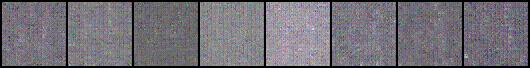

[Epoch 47] [Batch 295/296] [D loss: -0.543132] [G loss: 4.754772]


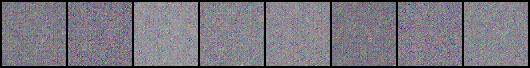

[Epoch 48] [Batch 295/296] [D loss: -0.424552] [G loss: 1.803638]


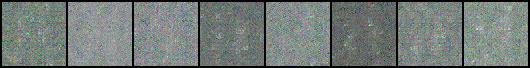

[Epoch 49] [Batch 295/296] [D loss: 1.732813] [G loss: 3.809057]


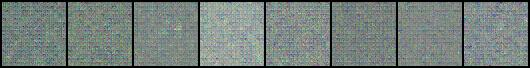

[Epoch 50] [Batch 295/296] [D loss: 0.579243] [G loss: 0.265080]


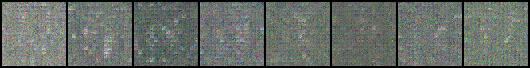

[Epoch 51] [Batch 295/296] [D loss: 2.253173] [G loss: 1.070893]


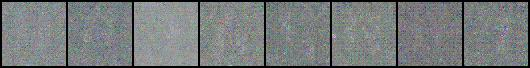

[Epoch 52] [Batch 295/296] [D loss: 4.507073] [G loss: 8.371450]


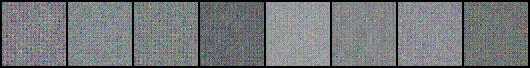

[Epoch 53] [Batch 295/296] [D loss: 1.583705] [G loss: 0.610406]


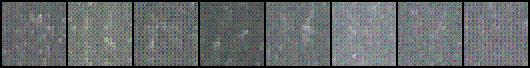

[Epoch 54] [Batch 295/296] [D loss: -2.117461] [G loss: -0.339787]


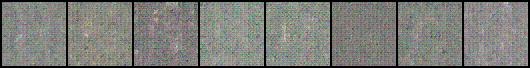

[Epoch 55] [Batch 295/296] [D loss: 4.420710] [G loss: 2.168934]


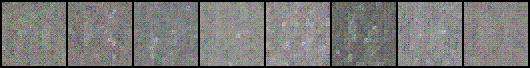

[Epoch 56] [Batch 295/296] [D loss: 6.692000] [G loss: 2.490542]


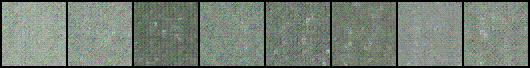

[Epoch 57] [Batch 295/296] [D loss: 5.536442] [G loss: 3.039938]


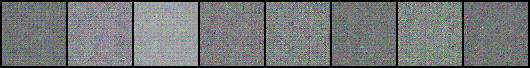

[Epoch 58] [Batch 295/296] [D loss: -3.202311] [G loss: 3.955405]


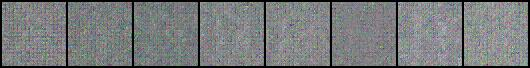

[Epoch 59] [Batch 295/296] [D loss: -0.586238] [G loss: -6.855618]


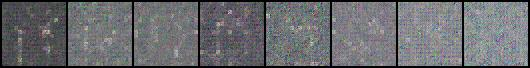

[Epoch 60] [Batch 295/296] [D loss: -0.874550] [G loss: 1.327726]


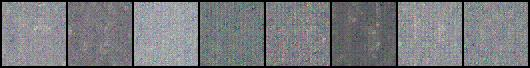

[Epoch 61] [Batch 295/296] [D loss: 1.701626] [G loss: 4.389435]


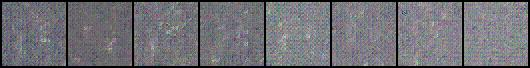

[Epoch 62] [Batch 295/296] [D loss: 3.706834] [G loss: -0.055531]


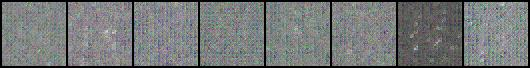

[Epoch 63] [Batch 295/296] [D loss: -1.276499] [G loss: -5.821356]


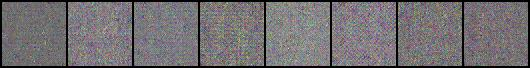

[Epoch 64] [Batch 295/296] [D loss: 0.200294] [G loss: 1.791296]


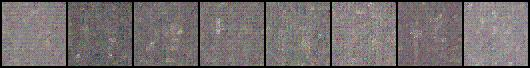

[Epoch 65] [Batch 295/296] [D loss: -0.444032] [G loss: 2.714227]


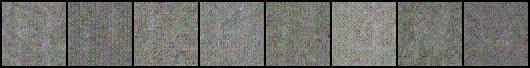

[Epoch 66] [Batch 295/296] [D loss: 5.501941] [G loss: 1.187104]


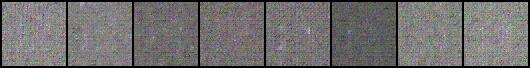

[Epoch 67] [Batch 295/296] [D loss: -1.477736] [G loss: 1.103563]


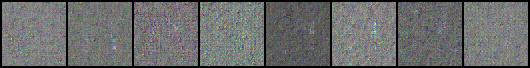

[Epoch 68] [Batch 295/296] [D loss: -1.121633] [G loss: 1.060821]


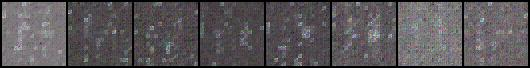

[Epoch 69] [Batch 295/296] [D loss: 2.172181] [G loss: 3.740982]


In [8]:
best = 1e4

for epoch in range(epoch):
    lr_schedulers = (gen_scheduler, dis_scheduler) if lr_decay else None

    train(
        noise,
        generator,
        discriminator,
        optim_gen,
        optim_dis,
        epoch,
        lr_schedulers,
        img_size=64,
        latent_dim=latent_dim,
        n_critic=n_critic,
    )